In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

df_original = pd.read_excel('./Manual_base.xlsx')
df_original = df_original[((df_original['GDP, $bln'] != 0) &
                           (df_original['Date'].dt.month
                            == 10))]  # Используем только данные за 4ый квартал и ВВП !=0
df_original['Year'] = df_original['Date'].dt.year
df_original.sort_values(['Country','Year'], ignore_index=True, inplace=True)

COLUMNS = {
    'date':
    'Date',
    'year':
    'Year',
    'country':
    'Country',
    'region':
    'Region',
    'gdp':
    'GDP, $bln',
    'net_dividends_paid_by_nonfin_corp':
    'Net Dividends Paid By Nonfinancial Corporates',
    'net_dividends_paid_by_fin_corp':
    'Net Dividends Paid By Financial Corporates',
    'dividends_paid_abroad':
    'Dividends Paid Abroad',
    'fpi_into_domestic_equity_level':
    'FPI into Domestic Equity LEVEL',
    'fdi_into_domestic_equity_level':
    'FDI into Domestic Equity LEVEL',
    'domestic_companies_mrk_cap':
    'Domestic Public Companeis MktCap\n// INTERPOLATED',
    'domestic_companies_cap':
    'Domestic Companeis Capitalization\n// INTERPOLATED',
    'bop_implied_dividends_yield':
    'BOP-implied Dividends Yield, %',
    'net_dividends_paid_by_fin_corp_divide_gdp':
    'Net Dividends Paid By Financial Corporates / GDP %',
    'net_dividends_paid_by_nonfin_corp_divide_gdp':
    'Net Dividends Paid By Nonfinancial Corporates / GDP %',
    'dividends_paid_abroad_divide_gdp':
    'Dividends Paid Abroad, %GDP',
    'fdi_into_domestic_equity_level_divide_gdp':
    'FDI into Domestic Equity LEVEL / GDP %',
    'fpi_into_domestic_equity_level_divide_gdp':
    'FPI into Domestic Equity LEVEL / GDP %',
    'domestic_companies_mrk_cap_divide_gdp':
    'Domestic Companies MrkСap, $bln / GDP, %',
    
    'd_fixed_assets_of_nonfin_corp':
    'Δ Fixed Assets of Nonfinancial Corporates',
    'd_fixed_assets_of_fin_corp':
    'Δ Fixed Assets of Financial Corporates',
    'd_fixed_assets_of_noncorp':
    'Δ Fixed Assets of Noncorporates',
    'd_fixed_assets_of_nonfin_corp / d_fixed_assets_of_corp':
    'Δ Fixed Assets of Nonfinancial Corporates / (Δ Fixed Assets of Nonfinancial Corporates + Δ Fixed Assets of Financial Corporates)',
    'd_fixed_assets_of_corp / d_fixed_assets_of_total_econ':
    'Δ Fixed Assets of Corporates / Δ Fixed Assets of Total Economy',
    'd_fixed_assets_of_total_econ':
    'Δ Fixed Assets (excl. Inventories) of Total Economy',
    'd_inventories_of_total_econ':
    'Δ Inventories of Total Economy',
    
    'd_net_debt_of_gen_gov':
    'Δ Net Debt of General Government',
    'gov_deficit_gdp':
    'Government Deficit, %GDP', 
    'd_net_debt_of_nonfin_corp':
    'Δ Net Debt of Nonfinancial Corporates',
    'd_net_debt_of_fin_corp':
    'Δ Net Debt of Financial Corporates',  
    'd_net_debt_of_noncorp':
    'Δ Net Debt of Noncorporates',
    'pers_disp_income':
    'Personal Disposable Income',
    'pers_disp_income_gdp':
    'Personal Disposable Income, %GDP',
    'pers_saving_ratio':
    'Personal Saving Ratio',
    'd_net_debt_of_hh':
    'Δ Net Debt of Households and NISH',
    'd_net_debt_of_hh / pers_saving':
    'Delta Net Debt of HH / Personal Saving',
    'curr_account':
    'Current Account',
    'curr_account_divide_gdp':
    'Current Account / GDP'
}

existed_columns = set(COLUMNS.values()).intersection(df_original.columns)
missed_columns = set(COLUMNS.values()).difference(existed_columns)
df = df_original[existed_columns]
df = pd.concat([df, pd.DataFrame(columns=list(missed_columns))])

df.rename(columns={value: key for key, value in COLUMNS.items()}, inplace=True)
df = df.astype({'year': np.int64})
df.set_index(['year', 'region', 'country'], inplace=True)

def check_possible_for_trand_line(lst: pd.Series,
                                  count_in_a_row: int = 5) -> bool:
    """ Проверяем возможно ли построить линию тренда (требуется count_in_a_row точек подряд) """
    return lst.rolling(count_in_a_row).sum().notna().sum() > 0


def my_interpolate(original_lst):
    original_lst: pd.Series = original_lst
    index_min = original_lst.index[0]
    index_max = original_lst.index[-1]
    x1, x2 = 1, 5

    
    def pointwise(x0):
        direction = get_direction(x0)
        if direction:
            f_x1 = original_lst.loc[x0 - x1 * direction]
            f_x2 = original_lst.loc[x0 - x2 * direction]
            original_lst.loc[x0] = f_x1 + (0 - x1) * ((f_x2 - f_x1) / (x2 - x1))
            
    
    def get_direction(x0):
        direction = None
        if (x0 - x2 >= index_min) and original_lst.loc[x0 - x2:x0 -
                                                       1].isnull().sum() == 0:
            direction = 1
        elif (x0 + x2 <= index_max) and (
                original_lst.loc[x0 + 1:x0 + x2].isnull().sum() == 0):
            direction = -1
        return direction
    
    def ufunclike(xs):
        list(map(pointwise, xs))


    return ufunclike

def set_values_by_line_trand(df: pd.DataFrame, column_name: str) -> None:
    """ Проставляет значения в колонках columns по алгоритму линейной интер/экстраполяции """
    def f(dfGroupBy):
        lst = dfGroupBy[column_name]
        if 0 < lst.isna().sum(
        ) < len(lst) - 5 and check_possible_for_trand_line(lst):
            f_x = my_interpolate(lst)
            f_x(lst[lst.isna()].index.to_list()[::-1])
            f_x(lst[lst.isna()].index.to_list()[::1])
            df[column_name].fillna(lst, inplace=True)
            #df[column_name] = np.maximum(df[column_name], 0)

    df.reset_index(inplace=True)
    df.groupby('country').apply(f)
    #df.set_index(['region', 'year', 'country'], inplace=True)
    df.set_index(['year', 'region', 'country'], inplace=True)
    
def set_values_by_mean_years(df: pd.DataFrame, column_name: str):
    """ Проставляет значения в колонках columns используя среднее значение за год по всему региону"""
    tmp = df[column_name].groupby(['region', 'year']).mean()
    df[column_name].fillna(tmp.swaplevel(0, 1), inplace=True)
    
def set_values_by_mean_region(df: pd.DataFrame, column_name: str) -> None:
    """ Проставляет значения в колонках columns используя среднее значение за все время по всему региону"""
    df.reset_index(inplace=True)
    df.set_index(['region', 'year', 'country'], inplace=True)
    avgs_by_region = df[column_name].groupby(['region']).mean()
    avgs_by_region.index = pd.MultiIndex.from_arrays([avgs_by_region.index], names=["region"])
    df[column_name].fillna(avgs_by_region, inplace=True)

# Получение компонента "Net Dividends Paid By Nonfinancial Corporates"

In [10]:
df['net_dividends_paid_by_nonfin_corp_divide_gdp'] = (
    df['net_dividends_paid_by_nonfin_corp'] / df['gdp'])
df['net_dividends_paid_by_fin_corp_divide_gdp'] = (
    df['net_dividends_paid_by_fin_corp'] / df['gdp'])
df['dividends_paid_abroad_divide_gdp'] = (
    df['dividends_paid_abroad'] / df['gdp'])
df['fdi_into_domestic_equity_level_divide_gdp'] = (
    df['fdi_into_domestic_equity_level'] / df['gdp'])
df['fpi_into_domestic_equity_level_divide_gdp'] = (
    df['fpi_into_domestic_equity_level'] / df['gdp'])
df['domestic_companies_mrk_cap_divide_gdp'] = (
    df['domestic_companies_mrk_cap'] / df['gdp'])

set_values_by_line_trand(df, "dividends_paid_abroad_divide_gdp")
set_values_by_line_trand(df, "fdi_into_domestic_equity_level_divide_gdp")
set_values_by_line_trand(df, "fpi_into_domestic_equity_level_divide_gdp")
set_values_by_line_trand(df, "domestic_companies_mrk_cap_divide_gdp")
set_values_by_line_trand(df, 'net_dividends_paid_by_nonfin_corp_divide_gdp')
set_values_by_line_trand(df, 'net_dividends_paid_by_fin_corp_divide_gdp')

set_values_by_mean_years(df, 'dividends_paid_abroad_divide_gdp')
set_values_by_mean_years(df, 'fdi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_years(df, 'fpi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_years(df, 'domestic_companies_mrk_cap_divide_gdp')
set_values_by_mean_years(df, 'net_dividends_paid_by_nonfin_corp_divide_gdp')
set_values_by_mean_years(df, 'net_dividends_paid_by_fin_corp_divide_gdp')

set_values_by_mean_region(df, 'dividends_paid_abroad_divide_gdp')
set_values_by_mean_region(df, 'fdi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_region(df, 'fpi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_region(df, 'domestic_companies_mrk_cap_divide_gdp')

df['dividends_paid_abroad'].fillna(
    value=df['dividends_paid_abroad_divide_gdp'] * df['gdp'],
    inplace=True)
df['fdi_into_domestic_equity_level'].fillna(
    value=df['fdi_into_domestic_equity_level_divide_gdp'] *
    df['gdp'],
    inplace=True)
df['fpi_into_domestic_equity_level'].fillna(
    value=df['fpi_into_domestic_equity_level_divide_gdp'] *
    df['gdp'],
    inplace=True)
df['domestic_companies_mrk_cap'].fillna(
    value=df['domestic_companies_mrk_cap_divide_gdp'] * df['gdp'],
    inplace=True)
df['domestic_companies_cap'].fillna(
    value=df[['domestic_companies_mrk_cap', 'fpi_into_domestic_equity_level'
              ]].max(axis=1) + df['fdi_into_domestic_equity_level'].fillna(0),
    inplace=True)
df['bop_implied_dividends_yield'].fillna(
    value=df['dividends_paid_abroad'] / (df['fdi_into_domestic_equity_level'].fillna(0) +
                                         df['fpi_into_domestic_equity_level'].fillna(0)),
    inplace=True)

# рассчитываем основной компонент

set_values_by_line_trand(
    df, 'net_dividends_paid_by_nonfin_corp_divide_gdp')
df['net_dividends_paid_by_nonfin_corp'].fillna(
    value=df['net_dividends_paid_by_nonfin_corp_divide_gdp'] *
    df['gdp'],
    inplace=True)
df['net_dividends_paid_by_nonfin_corp'].fillna(
    value=df['domestic_companies_cap'] * df['bop_implied_dividends_yield'] -
    df['dividends_paid_abroad'],
    inplace=True)

set_values_by_line_trand(
    df, 'net_dividends_paid_by_fin_corp_divide_gdp')
df['net_dividends_paid_by_fin_corp'].fillna(
    value=df['net_dividends_paid_by_fin_corp_divide_gdp'] *
    df['gdp'],
   inplace=True)

df['net_dividends_paid_by_nonfin_corp'].fillna(
    value=df['net_dividends_paid_by_fin_corp_divide_gdp'] *
    df['gdp'],
   inplace=True)
# df['net_dividends_paid_by_nonfin_corp'].isna().sum() # Если не 0, тогда что-то не рассчиталось

# Получение компонента Δ Fixed Assets

In [9]:
df['d_fixed_assets_of_nonfin_corp / d_fixed_assets_of_corp'] = (
    df['d_fixed_assets_of_nonfin_corp'] / (df['d_fixed_assets_of_nonfin_corp']+df['d_fixed_assets_of_fin_corp']))
df['d_fixed_assets_of_corp / d_fixed_assets_of_total_econ'] = (
    (df['d_fixed_assets_of_nonfin_corp']+df['d_fixed_assets_of_fin_corp']) / df['d_fixed_assets_of_total_econ'])
df['d_fixed_assets_of_noncorp / d_fixed_assets_of_total_econ'] = (
    (df['d_fixed_assets_of_nonfin_corp']+df['d_fixed_assets_of_fin_corp']) / df['d_fixed_assets_of_total_econ'])
df['d_fixed_assets_of_corp / d_fixed_assets_of_total_econ'] = (
    (df['d_fixed_assets_of_nonfin_corp']+df['d_fixed_assets_of_fin_corp']) / df['d_fixed_assets_of_total_econ'])
df['d_fixed_assets_of_noncorp / d_fixed_assets_of_total_econ'] = (
    (df['d_fixed_assets_of_noncorp']) / df['d_fixed_assets_of_total_econ'])

set_values_by_line_trand(df, 'd_fixed_assets_of_total_econ')
set_values_by_line_trand(df, 'd_fixed_assets_of_nonfin_corp / d_fixed_assets_of_corp')
set_values_by_line_trand(df, 'd_fixed_assets_of_corp / d_fixed_assets_of_total_econ')
set_values_by_line_trand(df, 'd_inventories_of_total_econ')
set_values_by_line_trand(df,'d_fixed_assets_of_noncorp / d_fixed_assets_of_total_econ')


set_values_by_mean_years(df, 'd_fixed_assets_of_total_econ')
set_values_by_mean_years(df, 'd_fixed_assets_of_nonfin_corp / d_fixed_assets_of_corp')
set_values_by_mean_years(df, 'd_fixed_assets_of_corp / d_fixed_assets_of_total_econ')
set_values_by_mean_years(df, 'd_inventories_of_total_econ')
set_values_by_mean_years(df, 'd_fixed_assets_of_noncorp / d_fixed_assets_of_total_econ')

set_values_by_mean_region(df, 'd_fixed_assets_of_total_econ')
set_values_by_mean_region(df, 'd_fixed_assets_of_nonfin_corp / d_fixed_assets_of_corp')
set_values_by_mean_region(df, 'd_fixed_assets_of_corp / d_fixed_assets_of_total_econ')
set_values_by_mean_region(df, 'd_inventories_of_total_econ')
set_values_by_mean_region(df, 'd_fixed_assets_of_noncorp / d_fixed_assets_of_total_econ')

df['d_fixed_assets_of_nonfin_corp'].fillna(df['d_fixed_assets_of_total_econ']* df['d_fixed_assets_of_nonfin_corp / d_fixed_assets_of_corp']*df['d_fixed_assets_of_corp / d_fixed_assets_of_total_econ']+df['d_inventories_of_total_econ'], inplace=True)
df['d_fixed_assets_of_fin_corp'].fillna(df['d_fixed_assets_of_total_econ']*(1-df['d_fixed_assets_of_nonfin_corp / d_fixed_assets_of_corp'])*df['d_fixed_assets_of_corp / d_fixed_assets_of_total_econ'], inplace=True)
df['d_fixed_assets_of_noncorp'].fillna(df['d_fixed_assets_of_total_econ']*df['d_fixed_assets_of_noncorp / d_fixed_assets_of_total_econ'], inplace=True)

# Получение компонента Δ Net Debt

In [11]:
set_values_by_line_trand(df, 'gov_deficit_gdp')
set_values_by_line_trand(df, 'd_net_debt_of_nonfin_corp')
set_values_by_line_trand(df, 'd_net_debt_of_fin_corp')
set_values_by_line_trand(df, 'pers_disp_income_gdp')
set_values_by_line_trand(df, 'pers_saving_ratio')
set_values_by_line_trand(df, 'd_net_debt_of_hh / pers_saving')

set_values_by_mean_years(df, 'gov_deficit_gdp')
set_values_by_mean_years(df, 'd_net_debt_of_nonfin_corp')
set_values_by_mean_years(df, 'd_net_debt_of_fin_corp')
set_values_by_mean_years(df, 'pers_disp_income_gdp')
set_values_by_mean_years(df, 'pers_saving_ratio')
set_values_by_mean_years(df, 'd_net_debt_of_hh / pers_saving')

set_values_by_mean_region(df, 'gov_deficit_gdp')
set_values_by_mean_region(df, 'd_net_debt_of_nonfin_corp')
set_values_by_mean_region(df, 'd_net_debt_of_fin_corp')
set_values_by_mean_region(df, 'pers_disp_income_gdp')
set_values_by_mean_region(df, 'pers_saving_ratio')
set_values_by_mean_region(df, 'd_net_debt_of_hh / pers_saving')


df['d_net_debt_of_gen_gov'].fillna(-df['gov_deficit_gdp']*df['gdp'], inplace=True)
df['d_net_debt_of_noncorp'].fillna(df['d_fixed_assets_of_noncorp'], inplace=True)
df['pers_disp_income'].fillna(df['pers_disp_income_gdp']*df['gdp'], inplace=True)
df['d_net_debt_of_hh / pers_saving'].fillna(df['d_net_debt_of_hh']/(df['pers_disp_income']*df['pers_saving_ratio']), inplace=True)
df['d_net_debt_of_hh'].fillna(df['pers_disp_income']*df['pers_saving_ratio']*df['d_net_debt_of_hh / pers_saving']-df['d_net_debt_of_noncorp'], inplace=True)

# Получение компонента Current Account

In [12]:
set_values_by_line_trand(df, 'curr_account_divide_gdp')
set_values_by_mean_years(df, 'curr_account_divide_gdp')
set_values_by_mean_region(df, 'curr_account_divide_gdp')

df['curr_account'].fillna(value=df['curr_account_divide_gdp'] * df['gdp'], inplace=True)

# Сохранение результата

In [13]:
if len(df.index.names) > 1: 
    df.reset_index(inplace=True)

# форматируем таблицу для удобного визуального просмотра excel
tmp_df = df.copy()
tmp_df.drop(['date', 'gdp', 'country', 'region', 'year'], axis=1, inplace=True)
tmp_df.columns = [f'{val}_interpolated' for val in tmp_df.columns]
df_res = pd.concat([tmp_df, df_original], axis=1)
df_res.rename(columns={f'{key}_interpolated': f'{val} [interpolated]' for key, val in COLUMNS.items()}, inplace=True)
columns_1 = set(['Date', 'Country','Region', 'GDP, $bln'])
result_columns = list(columns_1)
result_columns.extend(sorted(list(set(df_res.columns.to_list()).difference(columns_1))))

df_res[result_columns].to_excel('./output.xlsx')


# График для проверки результата

<AxesSubplot:xlabel='Year'>

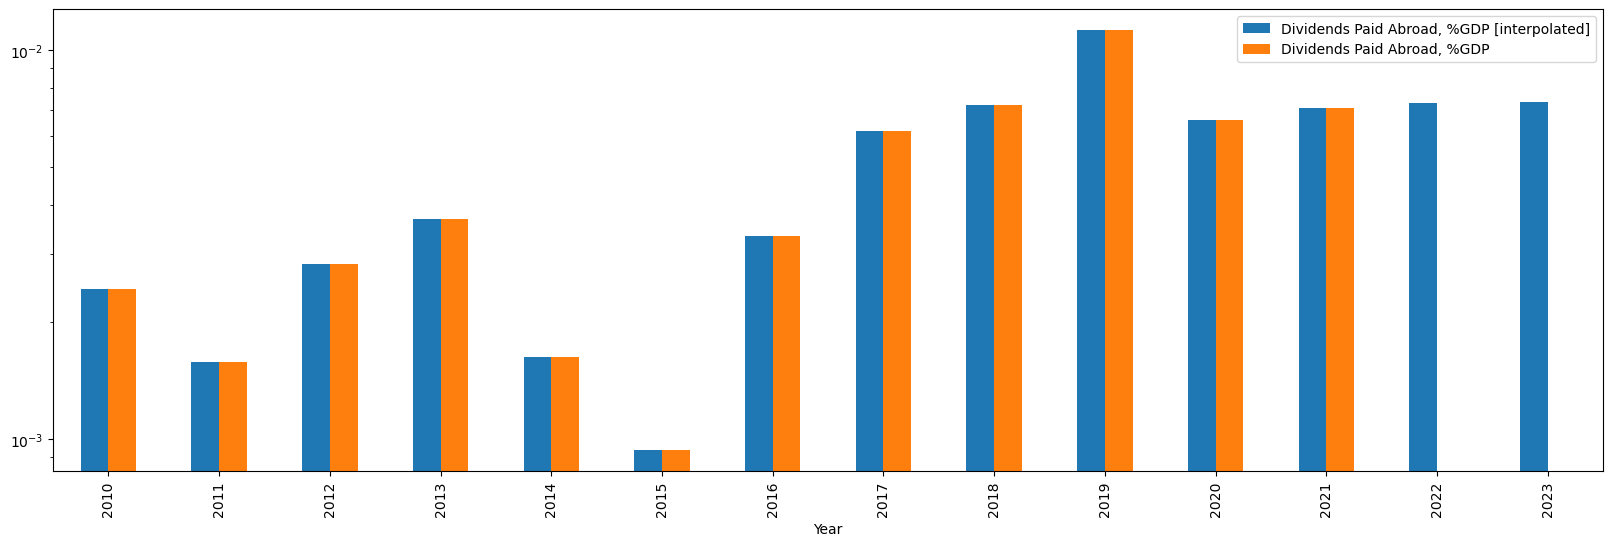

In [14]:
# Указать страну
country = 'Uzbekistan'
# Указать параметр(столбец)
column_interpolated = 'Dividends Paid Abroad, %GDP [interpolated]'
column_manual = 'Dividends Paid Abroad, %GDP'


df_output = pd.read_excel('./output.xlsx')
tmp = df_output[df_output['Country'] == country]
tmp = tmp[['Year', column_interpolated, column_manual]]
tmp.plot.bar(x='Year', figsize=(20, 6), logy=True) # логарифмическая шкаля Y 